In [1]:
from sklearn.utils import resample
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import seaborn as sns
from collections import Counter
import nltk
from sympy.physics.control.control_plots import plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud

rand_seed = 12
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/karlo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/karlo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Preprocessing

In [2]:
# A look at how the data is structured
file_path = 'data_text/300_TRANSCRIPT.csv'
df = pd.read_csv(file_path, delimiter='\t')
df.head()

,start_time,stop_time,speaker,value
0,36.588,39.668,Ellie,hi i'm ellie thanks for coming in today
1,39.888,43.378,Ellie,i was created to talk to people in a safe and ...
2,43.728,48.498,Ellie,think of me as a friend i don't judge i can't ...
3,49.188,52.388,Ellie,i'm here to learn about people and would love ...
4,52.658,58.958,Ellie,i'll ask a few questions to get us started and...


In [3]:
# Preprocessing the data
def preprocess_transcript(path):
    df = pd.read_csv(path, delimiter='\t')
    # Combine all rows of the 'value' column into one string
    transcript = ' '.join(df['value'].astype(str).tolist())
    # Clean the text
    transcript = re.sub(r'[^\w\s]', '', transcript.lower())
    return transcript


def preprocess_all_transcripts(path):
    data = {'label': [], 'transcript': []}

    for filename in os.listdir(path):
        if filename.endswith('.csv'):
            file_path = os.path.join(path, filename)
            try:
                label = int(filename.split('_')[0])
            except ValueError:
                continue  # Skip files that don't follow the naming convention
            transcript = preprocess_transcript(file_path)
            data['label'].append(label)
            data['transcript'].append(transcript)

    return pd.DataFrame(data)


def text_preprocessing(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)


transcript_folder_path = 'data_text'
phq_path = 'testing/full_test_split.csv'

df = preprocess_all_transcripts(transcript_folder_path)
phq_df = pd.read_csv(phq_path)
phq_df = phq_df[['Participant_ID', 'PHQ_Binary']]

df = df.merge(phq_df, how='left', left_on='label', right_on='Participant_ID')

df.drop(columns=['Participant_ID'], inplace=True)
df.dropna(subset=['PHQ_Binary'], inplace=True)

#print(df['PHQ_Binary'].value_counts()) # This is unbalanced

# Balancing the dataset by undersampling majority class
df_majority = df[df['PHQ_Binary'] == 0.0]
df_minority = df[df['PHQ_Binary'] == 1.0]

df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=14,
                                   random_state=rand_seed)

df_balanced = pd.concat([df_majority_downsampled, df_minority])
df = df_balanced

#print(df['PHQ_Binary'].value_counts())
df['transcript'] = df['transcript'].apply(text_preprocessing)
df.head()

,label,transcript,PHQ_Binary
28,438,synch introv4confirmation hi im ellie thanks c...,0.0
127,462,sync introv4confirmation hi im ellie thanks co...,0.0
102,408,sync introv4confirmation hi im ellie thanks co...,0.0
73,378,synch introv4confirmation hi im ellie thanks c...,0.0
7,396,synch introv4confirmation hi im ellie thanks c...,0.0


# Exploratory data analysis

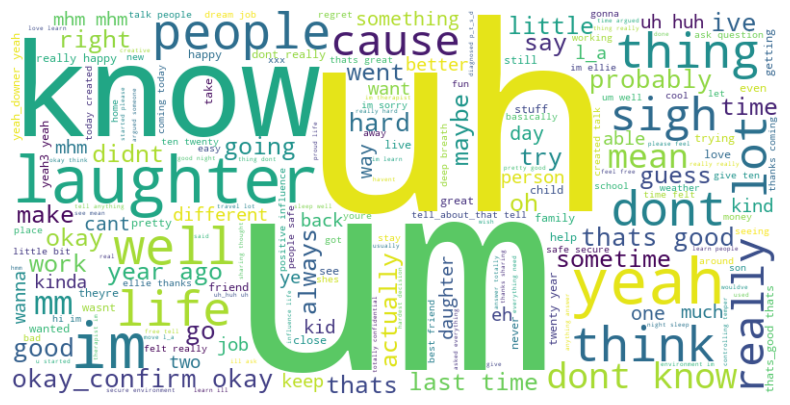

In [4]:

# Word Cloud for the text data
text = " ".join(df['transcript'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


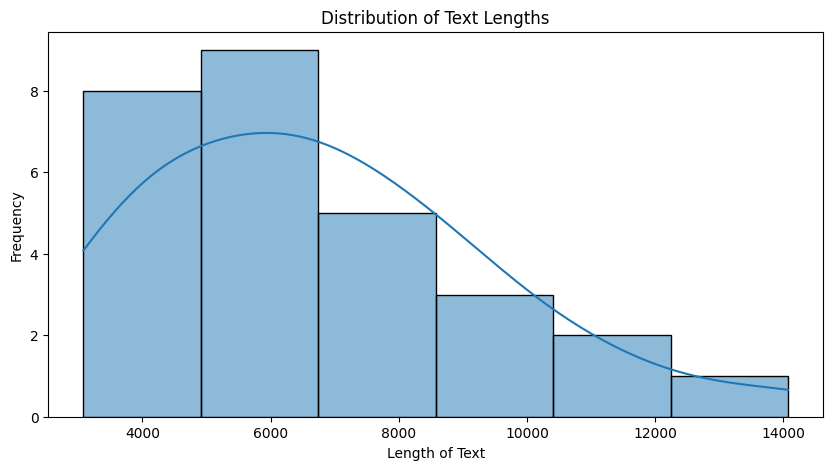

In [5]:

# Length of words
X_train_lengths = df['transcript'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(X_train_lengths, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()


[nltk_data] Downloading package punkt to /Users/karlo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


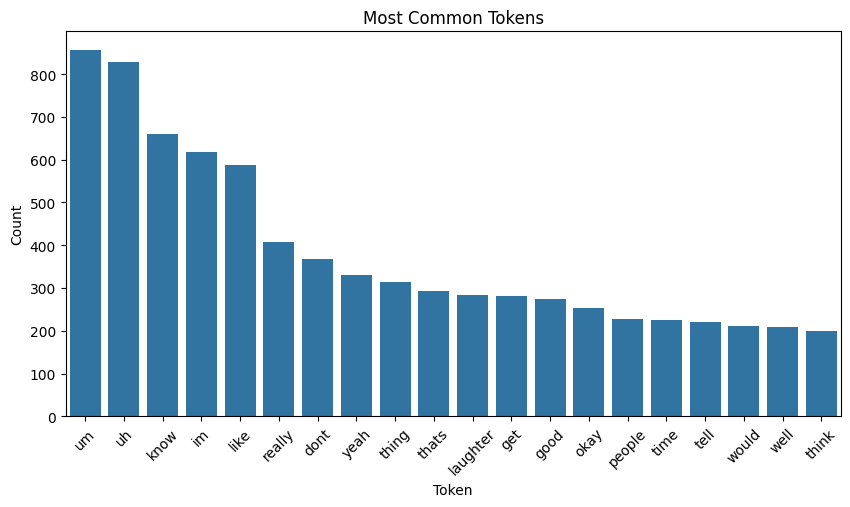

In [6]:

# Most common tokens

nltk.download('punkt')
all_tokens = nltk.word_tokenize(text)
common_tokens = Counter(all_tokens).most_common(20)

tokens_df = pd.DataFrame(common_tokens, columns=['Token', 'Count'])

plt.figure(figsize=(10, 5))
sns.barplot(data=tokens_df, x='Token', y='Count')
plt.title('Most Common Tokens')
plt.xlabel('Token')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


# Train test split

In [7]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['transcript'], df['PHQ_Binary'], test_size=0.2,
                                                    random_state=rand_seed)


# Creating the pipeline && hyperparameter tuning

In [8]:
# Create a pipeline with TF-IDF and a classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),  # Using bigrams
    ('clf', RandomForestClassifier(random_state=rand_seed))
])

# Hyperparameter tuning using Grid Search
param_grid = {
    'tfidf__max_df': [0.75, 1.0],
    'tfidf__min_df': [1, 2],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('clf',
                                        RandomForestClassifier(random_state=12))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 10, 20],
                         'clf__n_estimators': [100, 200],
                         'tfidf__max_df': [0.75, 1.0],
                         'tfidf__min_df': [1, 2]},
             scoring='accuracy')

# Evaluation

In [9]:
y_pred = grid_search.predict(X_test)

y_test = y_test.to_numpy()
# Debug: Check the shapes and types of y_pred
print(f'y_test: {y_test}')
print(f'y_pred: {y_pred}')

accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.2f}')

print("Best parameters found: ", grid_search.best_params_)


y_test: [0. 1. 1. 0. 0. 1.]
y_pred: [0. 1. 1. 1. 0. 1.]
Test Accuracy: 0.83
Best parameters found:  {'clf__max_depth': None, 'clf__n_estimators': 200, 'tfidf__max_df': 1.0, 'tfidf__min_df': 1}


## Classification Report and Confusion Matrix

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80         3
         1.0       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



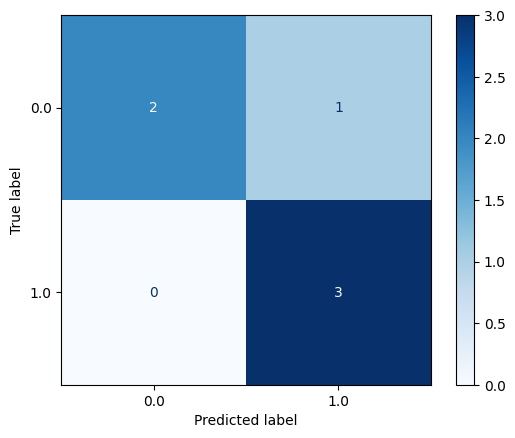

In [10]:
# Generate and display classification report

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate and display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=grid_search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()
